In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
from skimage.draw import disk
from skimage.segmentation import flood_fill
from skimage.segmentation import find_boundaries
from skimage.draw import polygon
from scipy.ndimage import binary_dilation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


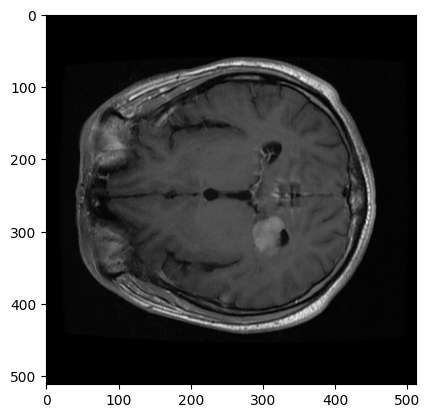

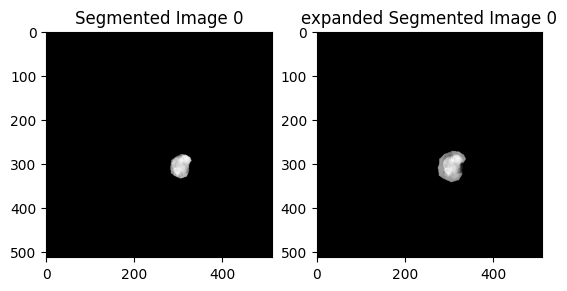

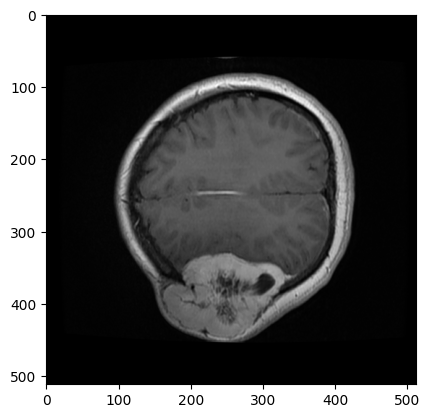

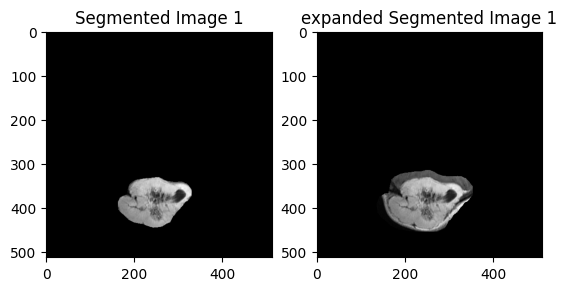

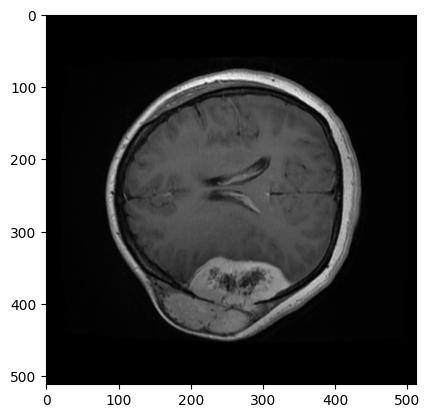

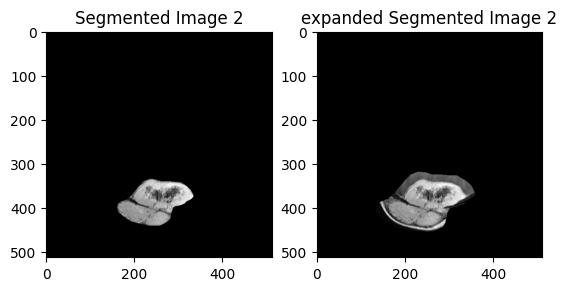

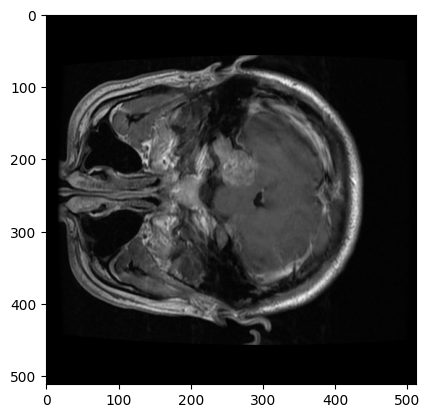

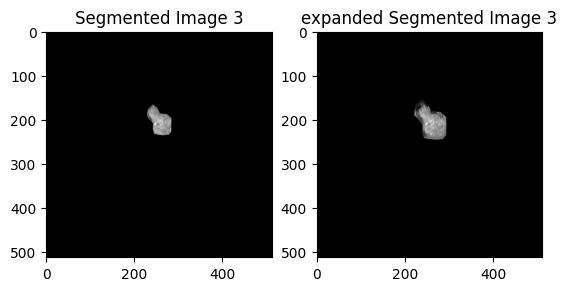

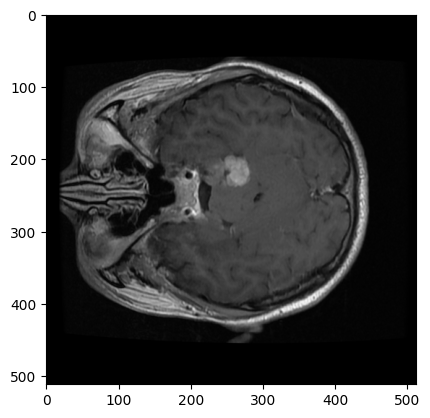

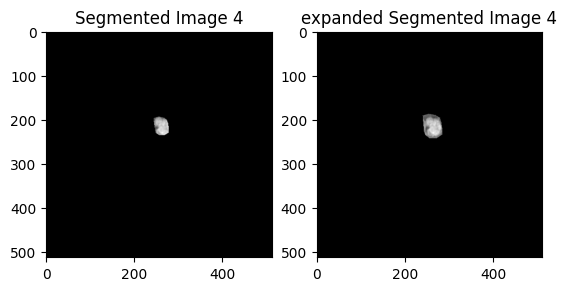

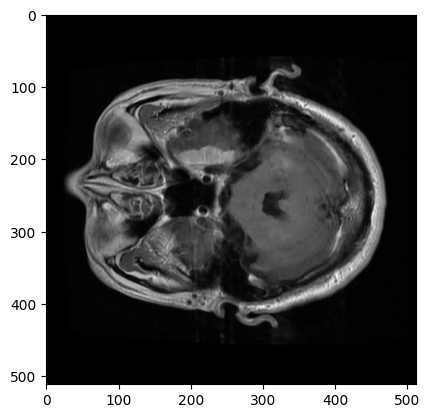

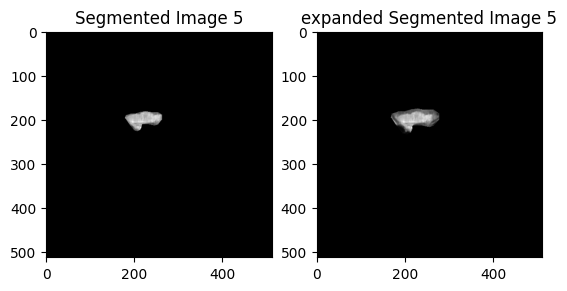

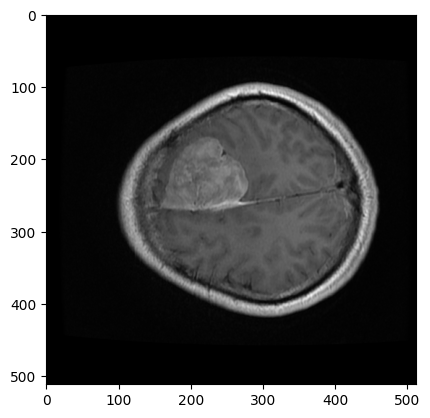

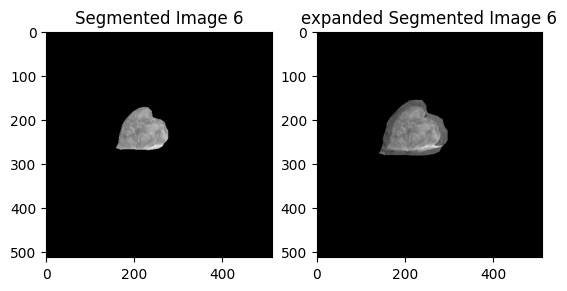

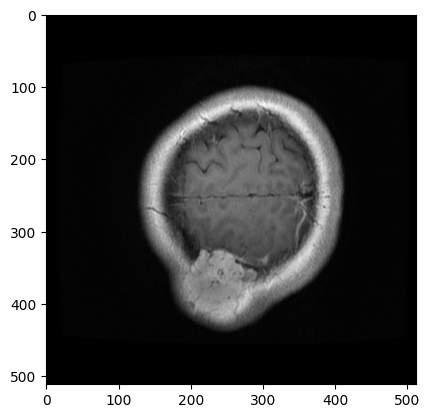

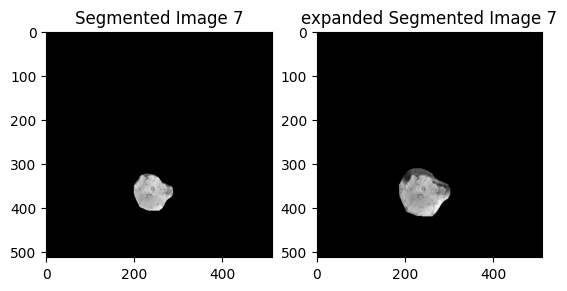

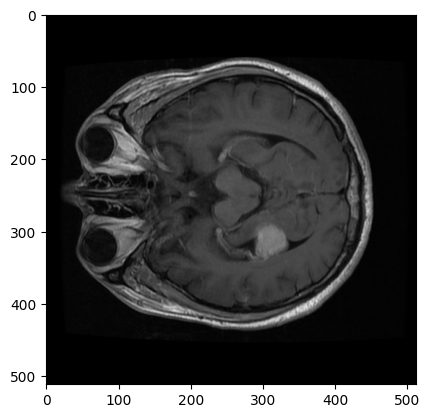

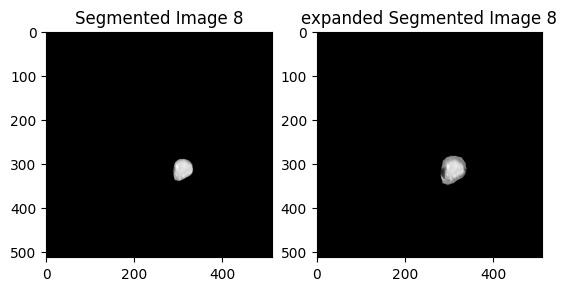

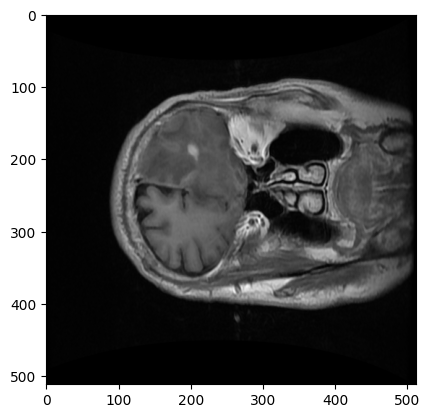

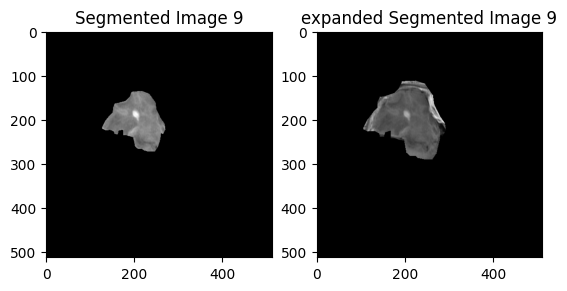

In [7]:
expanding_factor = 0.3
expanded_segmented_tumor_data = []

for data in all_data:
    image_data = data['image_data']
    tumor_border = data['tumor_border'][0]

    test = np.ones_like(image_data)
    expanded_segmented_region = np.zeros_like(image_data)

    # Extract x and y coordinates from tumor_border
    x_mean = np.mean([int(tumor_border[i]) for i in range(0, len(tumor_border), 2)])
    y_mean = np.mean([int(tumor_border[i + 1]) for i in range(0, len(tumor_border), 2)])
    expanded_x_coords = [int((int(tumor_border[i]) - x_mean)*expanding_factor+int(tumor_border[i]))for i in range(0, len(tumor_border), 2)]
    expanded_y_coords = [int((int(tumor_border[i+1]) - y_mean)*expanding_factor+int(tumor_border[i+1])) for i in range(0, len(tumor_border), 2)]
    # Create a filled polygon based on the tumor border
    rr, cc = polygon(expanded_y_coords, expanded_x_coords)
    # Ensure the indices are within image bounds
    rr = np.clip(rr, 0, image_data.shape[0] - 1)
    cc = np.clip(cc, 0, image_data.shape[1] - 1)
    # Set the pixels within the polygon to the corresponding values from the original image
    expanded_segmented_region[rr, cc] = test[rr, cc]
    expanded_segmented_region = np.rot90(np.fliplr(expanded_segmented_region))
    # Append the segmented region to the list
    expanded_segmented_tumor_data.append(np.where(expanded_segmented_region == 1,image_data, 0))
# Now you have the segmented images in the 'segmented_images' list
# You can access and process them as needed
for i in range(10):
    image_data = all_data[i]['image_data']
    plt.imshow(image_data,cmap = 'gray')
    plt.show()
    expanded_segmented_image = expanded_segmented_tumor_data[i]
    plt.subplot(1,2,1)
    plt.imshow(segmented_tumor_data[i], cmap='gray')
    plt.title(f"Segmented Image {i}")
    plt.subplot(1,2,2)
    plt.imshow(expanded_segmented_image, cmap='gray')
    plt.title(f"expanded Segmented Image {i}")
    plt.show()
# for i, segmented_image in enumerate(segmented_tumor_data):
#     # Display or save the segmented image
#     for i, expanded_segmented_image in enumerate(expanded_segmented_tumor_data):
#     # Display or save the segmented image
#         plt.subplot(1,2,2)
#         plt.imshow(expanded_segmented_image, cmap='gray')
#         plt.title(f"expanded Segmented Image {i}")
#         plt.subplot(1,2,1)
#         plt.imshow(segmented_image, cmap='gray')
#         plt.title(f"Segmented Image {i}")
#         plt.show()
#         break
#     break

(3064,)


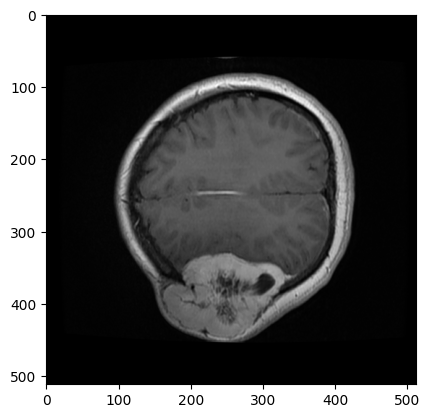

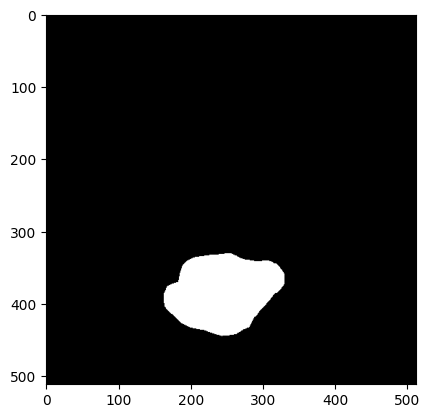

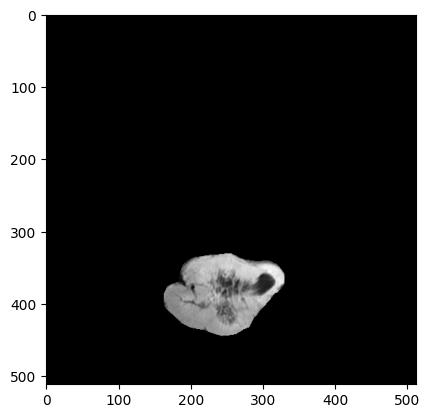

3064
3064
512


In [8]:
labels = np.array([item['label'] for item in all_data])
label_mapping = {1: 0, 2: 1, 3: 2}
labels = np.array([label_mapping[label] for label in labels])
print(labels.shape)

tumor_data = ([item['image_data'] for item in all_data])
plt.imshow(tumor_data[1],cmap='gray')
plt.show()

tumor_border = ([item['tumor_border'] for item in all_data])

tumor_mask = ([item['tumor_mask'] for item in all_data])

plt.imshow(tumor_mask[1],cmap='gray')
plt.show()
plt.imshow(segmented_tumor_data[1],cmap='gray')
plt.show()
print(len(tumor_data))
print(len(tumor_border))
print(len(expanded_segmented_region))

In [9]:
data_transforms = transforms.Compose([transforms.ToTensor(),lambda x: x.to(torch.float32)])
expanded_segmented_tumor_data = [data_transforms(image) for image in expanded_segmented_tumor_data]
expanded_segmented_tumor_data = [transforms.Resize((256,256))(image) for image in expanded_segmented_tumor_data]
data_train,data_test,label_train,label_test = train_test_split(expanded_segmented_tumor_data,labels,test_size=0.1)
train_data = list(zip(data_train, label_train))
test_data = list(zip(data_test, label_test))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [10]:
print(len(data_train),len(label_train))
print(len(data_test),len(label_test))
print(data_train[0].shape)

batch_size = 10

2757 2757
307 307
torch.Size([1, 256, 256])


In [11]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)

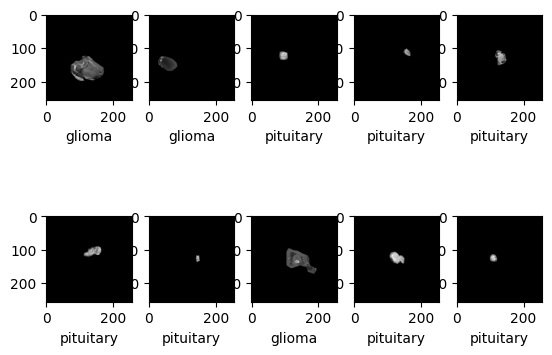

In [12]:
images,labels = next(iter(train_loader))
i=0
#1 for meningioma, 2 for glioma, 3 for pituitary tumor
classes = {0:'meningioma',1:'glioma',2:'pituitary'}
for i in range(len(images)):
    image = images[i]
    label = labels[i].item()
    i+=1
    plt.subplot(2,5,i)
    plt.imshow(image[0],cmap='gray')
    plt.xlabel(f'{classes[label]}')
plt.show()

In [13]:
data_loader = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train':2757,'val':307}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(torch.long)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Pretrained DensNet Model

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Load the pre-trained DenseNet model
model = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.DEFAULT)

# Modify the first convolution layer for 1-channel input, if necessary
model.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Unfreeze layers for fine-tuning (e.g., the last few layers)
for param in model.features.denseblock4.parameters():
    param.requires_grad = True

# Modify the classifier for 3-class output
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 3)  # Assuming 3 classes

# Set running mean and variance not to require gradients
if isinstance(model.features.norm5, nn.BatchNorm2d):
    model.features.norm5.running_mean.requires_grad = False
    model.features.norm5.running_var.requires_grad = False

# Move model to GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
# Note: You need to define the train_model function based on your dataset and training loop
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)


Epoch 1/20
----------
train Loss: 1.0939 Acc: 0.5959
val Loss: 1.6356 Acc: 0.6547
Epoch 2/20
----------
train Loss: 0.8728 Acc: 0.6754
val Loss: 0.6100 Acc: 0.7818
Epoch 3/20
----------
train Loss: 0.7272 Acc: 0.7432
val Loss: 0.6266 Acc: 0.7036
Epoch 4/20
----------
train Loss: 0.6537 Acc: 0.7534
val Loss: 0.9168 Acc: 0.7524
Epoch 5/20
----------
train Loss: 0.5549 Acc: 0.7994
val Loss: 11.6885 Acc: 0.3355
Epoch 6/20
----------
train Loss: 0.7041 Acc: 0.7461
val Loss: 2.2900 Acc: 0.7231
Epoch 7/20
----------
train Loss: 0.6291 Acc: 0.7860
val Loss: 0.5995 Acc: 0.8046
Epoch 8/20
----------
train Loss: 0.4359 Acc: 0.8299
val Loss: 0.2892 Acc: 0.8990
Epoch 9/20
----------
train Loss: 0.3810 Acc: 0.8469
val Loss: 0.2698 Acc: 0.9023
Epoch 10/20
----------
train Loss: 0.3516 Acc: 0.8643
val Loss: 0.3252 Acc: 0.8762
Epoch 11/20
----------
train Loss: 0.3528 Acc: 0.8542
val Loss: 0.3246 Acc: 0.8827
Epoch 12/20
----------
train Loss: 0.3469 Acc: 0.8604
val Loss: 0.2330 Acc: 0.9186
Epoch 13/20


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Load the pre-trained DenseNet model
model = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.DEFAULT)

# Modify the first convolution layer for 1-channel input, if necessary
model.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Modify the classifier for 3-class output
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 3)  # Assuming 3 classes

# Set running mean and variance not to require gradients
if isinstance(model.features.norm5, nn.BatchNorm2d):
    model.features.norm5.running_mean.requires_grad = False
    model.features.norm5.running_var.requires_grad = False

# Move model to GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
# Note: You need to define the train_model function based on your dataset and training loop
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)


Epoch 1/20
----------
train Loss: 1.1371 Acc: 0.5854
val Loss: 0.7852 Acc: 0.7231
Epoch 2/20
----------
train Loss: 0.9790 Acc: 0.6725
val Loss: 2.3812 Acc: 0.6221
Epoch 3/20
----------
train Loss: 0.8675 Acc: 0.6670
val Loss: 0.7012 Acc: 0.7036
Epoch 4/20
----------
train Loss: 0.8101 Acc: 0.7240
val Loss: 1.0484 Acc: 0.6352
Epoch 5/20
----------
train Loss: 0.7142 Acc: 0.7385
val Loss: 0.4914 Acc: 0.8013
Epoch 6/20
----------
train Loss: 0.5521 Acc: 0.7845
val Loss: 0.6524 Acc: 0.7915
Epoch 7/20
----------
train Loss: 0.6579 Acc: 0.7602
val Loss: 0.5494 Acc: 0.8176
Epoch 8/20
----------
train Loss: 0.4915 Acc: 0.8270
val Loss: 0.4783 Acc: 0.8371
Epoch 9/20
----------
train Loss: 0.4214 Acc: 0.8339
val Loss: 0.3152 Acc: 0.8827
Epoch 10/20
----------
train Loss: 0.4048 Acc: 0.8448
val Loss: 0.3063 Acc: 0.8664
Epoch 11/20
----------
train Loss: 0.3902 Acc: 0.8429
val Loss: 0.3041 Acc: 0.8795
Epoch 12/20
----------
train Loss: 0.3670 Acc: 0.8542
val Loss: 0.2493 Acc: 0.9121
Epoch 13/20
-

In [ ]:
pip install scikit-learn


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Load the pre-trained DenseNet model
model = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.DEFAULT)

# Modify the first convolution layer for 1-channel input, if necessary
model.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Modify the classifier for 3-class output
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 3)  # Assuming 3 classes

# Set running mean and variance not to require gradients
if isinstance(model.features.norm5, nn.BatchNorm2d):
    model.features.norm5.running_mean.requires_grad = False
    model.features.norm5.running_var.requires_grad = False

# Move model to GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
# Note: You need to define the train_model function based on your dataset and training loop
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)


Epoch 1/20
----------
train Loss: 1.0966 Acc: 0.5970
val Loss: 0.7997 Acc: 0.6026
Epoch 2/20
----------
train Loss: 0.8944 Acc: 0.6572
val Loss: 0.7075 Acc: 0.7134
Epoch 3/20
----------
train Loss: 0.7850 Acc: 0.7084
val Loss: 0.6761 Acc: 0.7231
Epoch 4/20
----------
train Loss: 0.7914 Acc: 0.7124
val Loss: 0.4288 Acc: 0.8306
Epoch 5/20
----------
train Loss: 0.6929 Acc: 0.7461
val Loss: 1.5344 Acc: 0.7166
Epoch 6/20
----------
train Loss: 0.6252 Acc: 0.7690
val Loss: 0.3504 Acc: 0.8762
Epoch 7/20
----------
train Loss: 0.5417 Acc: 0.7925
val Loss: 1.2573 Acc: 0.8339
Epoch 8/20
----------
train Loss: 0.4300 Acc: 0.8270
val Loss: 0.2847 Acc: 0.9088
Epoch 9/20
----------
train Loss: 0.3877 Acc: 0.8408
val Loss: 0.2308 Acc: 0.9186
Epoch 10/20
----------
train Loss: 0.3733 Acc: 0.8400
val Loss: 0.2160 Acc: 0.9349
Epoch 11/20
----------
train Loss: 0.3640 Acc: 0.8473
val Loss: 0.2259 Acc: 0.9218
Epoch 12/20
----------
train Loss: 0.3593 Acc: 0.8633
val Loss: 0.2555 Acc: 0.9023
Epoch 13/20
-

**VGG16**

In [16]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Load the pre-trained VGG16 model
model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)

# Modify the first convolution layer for 1-channel input, if necessary
model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# Unfreeze some layers for fine-tuning
# For example, unfreeze the last few convolutional layers
for param in model.features[-6:].parameters():
    param.requires_grad = True

# Modify the classifier for 3-class output
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 3)  # Assuming 3 classes
)

# Move model to GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
# Note: You need to define the train_model function based on your dataset and training loop
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)


Epoch 1/20
----------
train Loss: 0.8693 Acc: 0.6355
val Loss: 0.6719 Acc: 0.6189
Epoch 2/20
----------
train Loss: 0.6311 Acc: 0.7370
val Loss: 0.4479 Acc: 0.8371
Epoch 3/20
----------
train Loss: 0.5401 Acc: 0.7835
val Loss: 0.4572 Acc: 0.8371
Epoch 4/20
----------
train Loss: 0.4486 Acc: 0.8270
val Loss: 0.4883 Acc: 0.8176
Epoch 5/20
----------
train Loss: 0.3944 Acc: 0.8451
val Loss: 0.4401 Acc: 0.8339
Epoch 6/20
----------
train Loss: 0.3193 Acc: 0.8814
val Loss: 0.2754 Acc: 0.8893
Epoch 7/20
----------
train Loss: 0.2732 Acc: 0.8984
val Loss: 0.3145 Acc: 0.8893
Epoch 8/20
----------
train Loss: 0.1278 Acc: 0.9518
val Loss: 0.2424 Acc: 0.8990
Epoch 9/20
----------
train Loss: 0.1005 Acc: 0.9626
val Loss: 0.2255 Acc: 0.8958
Epoch 10/20
----------
train Loss: 0.0830 Acc: 0.9706
val Loss: 0.2237 Acc: 0.9121
Epoch 11/20
----------
train Loss: 0.0715 Acc: 0.9735
val Loss: 0.2170 Acc: 0.9153
Epoch 12/20
----------
train Loss: 0.0559 Acc: 0.9815
val Loss: 0.2383 Acc: 0.9153
Epoch 13/20
-